# 1. 定义算法
强化学习算法的模式都比较固定，一般包括sample（即训练时采样动作），predict（测试时预测动作），update（算法更新）以及保存模型和加载模型等几个方法，其中对于每种算法sample和update的方式是不同的，而其他方法就大同小异。

In [9]:
import numpy as np
import math
import gym
import turtle
import datetime
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

In [3]:
# 定义Q学习算法
class QLearning(object):
    def __init__(self, n_states, n_actions, cfg):
        self.n_actions = n_actions
        self.lr = cfg.lr
        self.gamma = cfg.gamma # 折扣因子
        self.epsilon = cfg.epsilon_start # 贪婪策略的初始值
        self.sample_count = 0
        self.epsilon_start = cfg.epsilon_start
        self.epsilon_end = cfg.epsilon_end
        self.epailon_decay = cfg.epsilon_decay
        self.Q_table = defaultdict(lambda: np.zeros(self.n_actions)) # 用嵌套字典存放状态-动作-状态-动作值（Q值）的映射。即Q表格
    
    def sample_action(self, state):
        '''采样动作，用于训练'''
        self.sample_count += 1
        self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
            math.exp(-1. * self.sample_count / self.epailon_decay) # epsilon指数衰减
        # epsilon-greedy策略
        if np.random.uniform(0, 1) > self.epsilon:
            # 选取Q(s,a)最大对应的动作
            action = np.argmax(self.Q_table[str(state)])
        else:
            # 随机选取动作
            action = np.random.randint(0, self.n_actions)
        return action
    
    def predict_action(self, state):
        '''预测动作，用于测试'''
        # 选取Q(s,a)最大对应的动作
        action = np.argmax(self.Q_table[str(state)])
        return action
    
    def update(self, state, action, reward, next_state, terminated):
        Q_predict = self.Q_table[str(state)][action]
        if terminated:
            Q_target = reward
        else:
            Q_target = reward + self.gamma * np.max(self.Q_table[str(next_state)])
        self.Q_table[str(state)][action] += self.lr * (Q_target - Q_predict)


# 2. 定义训练
强化学习的训练方式也比较固定：

```python
for i_ep in range(train_eps): # 遍历每个回合
    state = env_reset() # 重置环境, 重新开一局（即开始新的一个回合）
    while True: # 对于一些比较复杂的游戏可以设置每回合最大的步长，例如while es_step<100,就是每回合最大步长为100
        action = agent.sample(state) # 根据算法采样一个动作
        next_state, reward, terminated, _ = env.step(action) # 与环境进行一次动作交互
        agent.memory.push(state, action, reward, next_state, terminated) # 记录memory
        agent.update(state, action, reward, next_state, terminated) # 更新算法参数
        state = next_state # 更新状态
        if terminated: # 如果回合结束
            break # 回合结束，跳出循环
```
首先对于每个回合，回合开始时**环境需要重置**。我们可以在设置智能体在每回合数的最大步长，尤其是对于比较复杂的游戏，这样做的好处之一就是帮助智能体在训练中快速收敛，比如我们先验地知道最优解的大概步数，那么理论上智能体收敛时也应该是这个步数附近，设置最大步数可以方便智能体接近这个最优解。在每个回合中，智能体首先需要**采样**（sample），或者说用探索策略例如常见的$\epsilon-greedy$策略或UCB探索等等来选择一个动作。然后环境根据智能体选择的动作进行**交互**，得到反馈，包括下一个状态、奖励和是否终止。采样的过程是将当前的状态state作为输入，智能体采样输出动作action。然后根据环境采样出来的动作反馈出现一个状态以及相应的reward等信息。接下来对具有memory的智能体例如包含replay memory的DQN来说，需要将相应的transition（记住这个词，中文不好翻译，通常是状态、动作、奖励等信息）。紧接着就是**智能体更新**，对于深度强化学习此时一般从memory中随机采样一些transition进行更新，对于Qlearning一半是采样的上一次的transition。更新公式是比较关键的部分，但也很通用，一般基于值的算法更新公式都是一个套路如下:
$$
y_{j}= \begin{cases}r_{j} & \text { for terminal } s_{t+1} \\\ r_{j}+\gamma \max _{a^{\prime}} Q ( s_{t+1}, a^{\prime} ; \theta ) & \text { for non-terminal } s_{t+1}\end{cases}
$$
智能体更新完后，通常需要更新状态，即`state = next_state`，然后也会检查是否完成了这一回合的游戏，即`if terminated==True`，注意完成并不等于回合成功，也有可能是失败得太离谱（以后就知道了）。如果需要记录奖励、损失等可以让智能体将这个交互信息记录到记忆中，即`agent.memory.push(state, action, reward, next_state, terminated)`。
> 实际上项目中更多使用tensorboard来记录训练信息，方便可视化。

此外，一些复杂的强化学习不是一一次性写完代码就能收敛的，需要做一个**挑参侠**。为了检查我们参数调得好不好，可以在终端print出奖励、损失以及epsilon等随着回合数的变化，这点说明一下强化学习的训练过程一般都是先探索然后收敛的，官方的话就是权衡exploration and exploitation。

$\epsilon-greedy$策略的做法就是前期探索，然后逐渐减小探索率至慢慢收敛，也就是这个$\epsilon$。这个值越大如0.9寿命智能体90%的概率在随机探索，通常情况下会设置三个值，epsilon_start、epsilon_end和epsilon_decay，epsilson_start是开始探索的概率，epsilson_end是探索结束的概率，epsilson_decay是探索概率的衰减率，epsilson_decay越大，探索的概率越小。其中初始值一半是0.95不变，终止值是0.01，也就是说在收敛阶段让智能体保持很小的探索概率，这是因为智能体已经学出了一个不错的策略，但是保不齐还有更好的策略。

重要的是epsion_decay的设置，衰减太快了学来的策略往往过拟合，衰减的太慢会影响收敛的速度。强化学习的调参项比如深度学习是有过之而无不及，比较复杂。不止是epsilon_decay，还有其他一些参数，比如replay memory的大小、学习率、gamma等等。

强化学习的测试代码跟训练代码基本上是一样的。有几点不同如下：
1. 测试模型的过程是不需要更新的，这个是不言而喻的；
2. 测试代码不需要采样（sample）动作，相比之代替的是预测（sample）动作，其区别是采样动作时可能会食用各种策略如$\epsilon-greedy$策略，而预测动作不需要，只需要根据训练时学习好的Q表或者网络模型代入状态得到动作即可；
3. 测试过程终端一般只需要看奖励，不需要看epsilon等，反正它在测试中是无意义的。

最后，智能体需要根据记忆中的信息进行更新，即`agent.update(state, action, reward, next_state, terminated)`。

In [32]:
def train(cfg, env, agent):
    print("开始训练！") 
    print(f'环境：{cfg.env_name}, 算法：{cfg.algo_name}')
    #print(f'环境：{cfg.env_name}, 算法：{cfg.algo_name}, 设备：{cfg.device}')
    rewards = []
    for i_ep in range(cfg.train_eps):
        ep_reward = 0 # 一轮episode的reward
        state = env.reset(seed = cfg.seed) # 重置环境, 重新开一局（即开始新的一个episode）
        while True:
            action = agent.sample_action(state) # 根据算法采样一个动作
            next_state, reward, terminated, _ = env.step(action) # 与环境进行一个交互
            agent.update(state, action, reward, next_state, terminated) # Q学习算法更新
            state = next_state # 更新状态
            ep_reward += reward
            if terminated:
                break
        rewards.append(ep_reward)
        if (i_ep + 1) % 20 == 0:
            print(f"回合: {i_ep+1}/{cfg.train_eps}, 奖励：{ep_reward:.1f}, Epsilon: {agent.epsilon:.3f}")
    print("完成训练！")
    return {"rewards": rewards}

def test(cfg, env, agent):
    print("开始测试！")
    print(f"环境：{cfg.env_name}, 算法：{cfg.algo_name}")
    #print(f"环境：{cfg.env_name}, 算法：{cfg.algo_name}, 设备：{cfg.device}")
    rewards = [] # 记录所有回合的episode奖励
    for i_ep in range(cfg.test_eps):
        ep_reward = 0 # 一轮episode的reward
        state = env.reset(seed = cfg.seed)
        while True:
            action = agent.predict_action(state) # 根据算法选择一个动作
            next_state, reward, terminated,info = env.step(action) # 与环境进行一个交互
            state = next_state # 更新状态
            ep_reward += reward
            if terminated:
                break
        rewards.append(ep_reward)
        if (i_ep + 1) % 10 == 0:
            print(f"回合：{i_ep+1}/{cfg.test_eps}，奖励：{ep_reward:.1f}")
    print("完成测试！")
    return {"rewards": rewards}


# 3.定义环境
OpenAI Gym中其实集成了很多强化学习环境，足够学习，但是在做强化学习的应用中免不了要自己创建环境，比如在本项目中其实不太好找到Qlearning能学出来的环境，Qlearning实在是太弱了，需要足够简单的环境才行，因此本项目写了一个环境，一般环境接口最关键的部分即是reset和step。

In [33]:
class CliffWalkingWrapper(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
        self.t = None # Turtle
        self.unit = 50
        self.max_x = 12
        self.max_y = 4

    def draw_x_line(self, y, x0, x1, color = 'gray'):
        assert x1 > x0
        self.t.color(color)
        self.t.setheading(0)
        self.t.up()
        self.goto(x0, y)
        self.down()
        self.t.forward(x1 - x0)

    def draw_y_line(self, x, y0, y1, color = 'gray'):
        assert y1 > y0
        self.t.color(color)
        self.t.setheading(90)
        self.t.up()
        self.t.goto(x, y0)
        self.t.down()
        self.t.forward(y1 - y0)

    def draw_box(self, x, y, fillcolor="", line_color="gray"):
        self.t.up()
        self.t.goto(x * self.unit, y * self.unit)
        self.t.color(line_color)
        self.t.fillcolor(fillcolor)
        self.t.setheading(90)
        self.t.down()
        self.t.begin_fill()
        for i in range(4):
            self.t.forward(self.unit)
            self.t.right(90)
        self.t.end_fill()

    def move_player(self, x, y):
        self.t.up()
        self.t.heading(90)
        self.t.fillcolor("red")
        self.t.goto((x + 0.5) * self.unit, (y + 0.5) * self.unit)

    def render(self,):
        if self.t == None:
            self.t = turtle.Turtle()
            self.wn = turtle.Screen()
            self.wn.setup(self.unit * self.max_x + 100,
                          self.unit * self.max_y + 100)
            self.wn.setworldcoordinates(0, 0, self.unit * self.max_x,
                                        self.unit * self.max_y)
            self.t.shape("circle")
            self.t.width(2)
            self.t.speed(0)
            self.t.color("gray")
            for _ in range(2):
                self.t.forward(self.max_x * self.unit)
                self.t.left(90)
                self.t.forward(self.max_y * self.unit)
                self.t.left(90)
            for i in range(1, self.max_y):
                self.draw_x_line(
                    y = i * self.unit, x0=0, x1=self.max_x * self.unit
                )
            for i in range(1, self.max_x):
                self.draw_y_line(
                    x = i * self.unit, y0=0, y1=self.max_y * self.unit
                )
            
            for i in range(1, self.max_x - 1):
                self.draw_box(i, 0, "black")
            self.draw_box(self.max_x - 1, 0, "yellow")
            self.t.shape("turtle")

        x_pos = self.s % self.max_x # ?s在哪里定义的？gym.Wrapper？
        y_pos = self.max_y - 1 - int(self.s / self.max_x)
        self.move_player(x_pos, y_pos)


In [34]:
# 创建智能体和环境
def env_agent_config(cfg, seed=1):
    env = gym.make(cfg.env_name, new_step_api=True)
    env = CliffWalkingWrapper(env)
    n_states = env.observation_space.n # 状态维度
    n_actions = env.action_space.n # 动作维度
    agent = QLearning(n_states, n_actions, cfg)
    return env, agent

# 4.设置参数
至此所有Qleaning的模块就完成了，下面需要设置一些参数，方便“炼丹”。另外定义一个画图函数，用于描述奖励的变化。

In [35]:
class Config:
    '''配置参数'''
    def __init__(self):
        self.env_name = "CliffWalking-v0" # 环境名称
        self.algo_name = "Q-Learning" # 算法名称
        self.train_eps = 400 # 训练的episode数量
        self.test_eps = 20 # 测试的episode数量
        self.max_steps = 200 # 每条轨迹的最大步数
        self.epsilon_start = 0.95 # epsilon-greedy策略中的初始值
        self.epsilon_end = 0.01 # epsilon-greedy策略中的终止值
        self.epsilon_decay = 300 # epsilon-greedy策略中的衰减率
        self.gamma = 0.9 # 折扣因子
        self.lr = 0.1 # 学习率
        self.seed = 1 # 随机种子

In [38]:
def smooth(data, weight=0.9):
    '''用于平滑曲线'''
    last = data[0] # 保存一下第一个值
    smoothed = list()
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point # 计算平滑值
        smoothed.append(smoothed_val) # 保存平滑值
        last = smoothed_val
    return smoothed

def plot_rewards(rewards, title="learning curve"):
    sns.set()
    plt.figure() # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{title}")
    plt.xlim(0, len(rewards)) # 设置横坐标范围
    plt.xlabel("epsiodes")
    plt.plot(rewards, label = "rewards")
    plt.plot(smooth(rewards), label = "smoothed rewards")
    plt.legend()

# 5.我准备好了
海绵宝宝：我准备好了！

/Users/damonchang/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


开始训练！
环境：CliffWalking-v0, 算法：Q-Learning
回合: 20/400, 奖励：-80.0, Epsilon: 0.010
回合: 40/400, 奖励：-65.0, Epsilon: 0.010
回合: 60/400, 奖励：-40.0, Epsilon: 0.010
回合: 80/400, 奖励：-60.0, Epsilon: 0.010
回合: 100/400, 奖励：-28.0, Epsilon: 0.010
回合: 120/400, 奖励：-19.0, Epsilon: 0.010
回合: 140/400, 奖励：-28.0, Epsilon: 0.010
回合: 160/400, 奖励：-37.0, Epsilon: 0.010
回合: 180/400, 奖励：-26.0, Epsilon: 0.010
回合: 200/400, 奖励：-21.0, Epsilon: 0.010
回合: 220/400, 奖励：-13.0, Epsilon: 0.010
回合: 240/400, 奖励：-22.0, Epsilon: 0.010
回合: 260/400, 奖励：-20.0, Epsilon: 0.010
回合: 280/400, 奖励：-14.0, Epsilon: 0.010
回合: 300/400, 奖励：-13.0, Epsilon: 0.010
回合: 320/400, 奖励：-15.0, Epsilon: 0.010
回合: 340/400, 奖励：-15.0, Epsilon: 0.010
回合: 360/400, 奖励：-13.0, Epsilon: 0.010
回合: 380/400, 奖励：-13.0, Epsilon: 0.010
回合: 400/400, 奖励：-13.0, Epsilon: 0.010
完成训练！
开始测试！
环境：CliffWalking-v0, 算法：Q-Learning
回合：10/20，奖励：-13.0
回合：20/20，奖励：-13.0
完成测试！


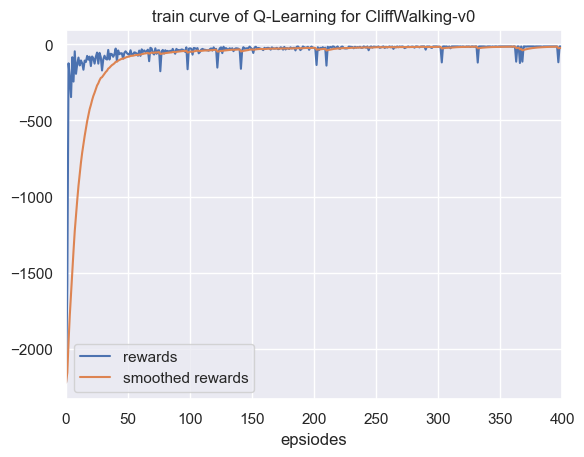

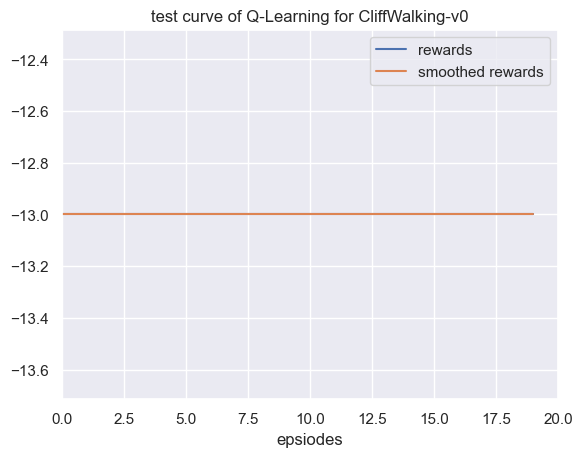

In [39]:
# 获取参数
cfg = Config()

env, agent = env_agent_config(cfg)

# 训练
res_dic = train(cfg, env, agent)
plot_rewards(res_dic["rewards"], title=f"train curve of {cfg.algo_name} for {cfg.env_name}")

# 测试
res_dic = test(cfg, env, agent)
plot_rewards(res_dic["rewards"], title=f"test curve of {cfg.algo_name} for {cfg.env_name}")

In [20]:
cfg.__dict__

{'env_name': 'CliffWalkinf-v0',
 'algo_name': 'Q-Learning',
 'train_eps': 400,
 'test_eps': 20,
 'max_steps': 200,
 'epsilon_start': 0.95,
 'epsilon_end': 0.01,
 'epislon_decay': 300,
 'gamma': 0.9,
 'lr': 0.1,
 'seed': 1}

核心过程是奖励机制，奖励如何定义？也就是reward的得到，具体还是在环境中。整个过程是机器学习算法为主，强化学习的机器学习算法主导着算法进行。